# Bootstrap and Resample Methods

### Data Sciene 410


## Introduction

Bootstrap and resampling methods are widely applicable statistical methods. Unlike the statistical methods we have encountered before, these methods are products of the computer age. By repeatedly resampling the data to relax many of the assumptions of clasical statistical methods. Resampling methods draw heavily on the central limit theorem (CLT). The trade-off is that resampling methods are compuationally intensive.   

Specifically resampling methods:

- Allow computation of statistics from limited data.
- Compute statistic from multiple subsamples of dataset.
- Make minimal distribution assumptions.
- Are computationally intensive.

Commonly used resampling methods include:

- Randomization or Permutation methods: e.g. Fisher's exact test.
- Bootstrap: resample with equivalent size and replacement.
- Jackknife: leave one out resampling.
- Cross validation: resample into multiple folds without replacement.


## Pitfalls

Resampling methods are general and powerful but, there is no magic involved. When using resampling methods always keep in mind the several pitfalls:
- If sample is biased, the resampled statistic estimate is biased.
- Sample variance and Cis can be no better than the data sample allows.

![](img/Tobaco.png)

<center>Misuse of inference</center>

## History

### Randomization and permutation methods

Randomization and permutation methods were pioneered by Fisher as early as 1911. Fisher fully developed the theory in his 1935 book. Scalability of these permutation methods remain limited, even with modern computers. 

### Cross-validaton

Today, cross-validation is widely used in the testing of machine learning models. Cross-validation was origianlly proposed by Kurtz in 1948. Mosier extended the method to double cross validation in 1951. The modern method of nested or multicoross-validation were introduced by Krus and Fuller in 1982. 

### Jack knife methods

Jack knife methods are often effective when there are only limited data samples. Maurice Quenouille originally suggested this method in 1949. The jack knife was fully developed
by John W. Tukey, who gave the method its name, in 1958. Tukey saw that method as a simple tool useful for many purposes like a pocket knife. 


### Bootstrap 

The bootstrap method was first suggested by Efron and Hinkley in 1978 and further developed by Efron in 1979. A full treatment was provided in Efron's 1980 book. 

![](img/Efron1980.jpg)

![](img/2014_Efron-outdoors.jpg)

With increased computing power, use of bootstrap methods continues to expand. 

## Overview of the bootstrap

The bootstrap method 

- Re-compute statistic many times with sample 
- Randomly sample (e.g. Bernoulli sample) data with replacement
- Subsamples have the same size as original sample
- Works with any statistic … in principle

For example, you can compute the bootstrap mean as:

$$Meanboot = \frac{\Sigma_i mean(sample_i)}{nsample}\\
where,\ for\ example\ with\ 10\ samples,\\
sample_i = X_1 + X_2 + X_3 + X_4 + X_5 + X_6 + X_7 + X_8 + X_1 + X_5$$

### Bootstrap example

Let's try a first example. You will bootstrap the means of the heights of different populations from Galton's height data. This is an example of a parametric bootstrap estimate. Parametric because our model has a parameter, the mean, we are trying to estimate. 

As a first step, the code in the cell below divides the data set by male and female adult children, and then plots the distributions with the means of the two populations. Run this code and examine the results.

In [1]:
import pandas
import numpy
from matplotlib import pyplot
import seaborn

%matplotlib inline

In [2]:
families = pandas.read_csv('GaltonFamilies.csv', index_col=0)
families.head()

,family,father,mother,midparentHeight,children,childNum,gender,childHeight
1,1,78.5,67.0,75.43,4,1,male,73.2
2,1,78.5,67.0,75.43,4,2,female,69.2
3,1,78.5,67.0,75.43,4,3,female,69.0
4,1,78.5,67.0,75.43,4,4,female,69.0
5,2,75.5,66.5,73.66,4,1,male,73.5


You can select a subset of rows from a dataframe that match a given condition like so (the condition is gender in this case):

In [3]:
male = families[families.gender == 'male']
female = families[families.gender == 'female']

len(male), len(female)

(481, 453)

Note that we can get the min or max of a series of values within a 
dataframe like so:

In [4]:
families.childHeight.min()

56.0

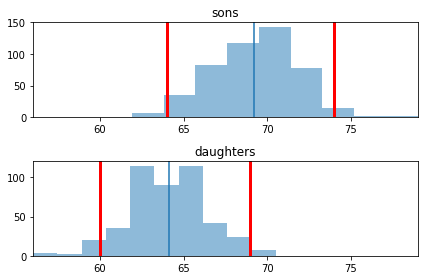

In [5]:
def plot_hist(x, xmin, xmax, p=5):
    # Plot the distribution and mark the mean
    pyplot.hist(x, alpha=.5)
    pyplot.axvline(x.mean())
    # 95% confidence interval    
    pyplot.axvline(numpy.percentile(x, p/2.), color='red', linewidth=3)
    pyplot.axvline(numpy.percentile(x, 100-p/2.), color='red', linewidth=3)
    pyplot.xlim( xmin, xmax )
    
def plot_dists(a, b, nbins, a_label='pop_A', b_label='pop_B', p=5):
    # Create a single sequence of bins to be shared across both
    # distribution plots for visualization consistency.
    combined = pandas.concat([a, b])
    xmin = combined.min()
    xmax = combined.max()
    breaks = numpy.linspace(
        xmin, xmax, 
        num=nbins+1)

    pyplot.subplot(2, 1, 1)
    plot_hist(a, xmin, xmax)
    pyplot.title(a_label)
    
    pyplot.subplot(2, 1, 2)
    plot_hist(b, xmin = xmin, xmax = xmax)
    pyplot.title(b_label)
    
    pyplot.tight_layout()
    

plot_dists(male.childHeight, female.childHeight, 20, a_label='sons', b_label='daughters')

You can see that the distributions of the heights of the sons and daughters overlap. But, are the means significantly different.

### Boot strap the means

Pandas has built-in support for generating bootstrap samples from a given dataframe. We'll use the `.sample()` method of our two dataframes to draw a single bootstrap sample like so:

In [6]:
female.sample(frac=1, replace=True).head()

,family,father,mother,midparentHeight,children,childNum,gender,childHeight
789,172,66.0,67.0,69.18,8,8,female,61.5
105,28,72.0,63.0,70.02,6,5,female,66.5
678,146,68.0,63.0,68.02,6,6,female,61.0
772,168,67.0,63.5,67.79,8,8,female,63.5
544,121,69.0,62.5,68.25,8,8,female,62.0


We can take the mean of our bootstrap sample in the same way as our full dataset dataframe:

In [7]:
female.sample(frac=1, replace=True).childHeight.mean()

63.965342163355444

Now we'll take many (`n_replicas`) bootstrap samples and plot the distribution of sample means as well as the mean of the sample means.

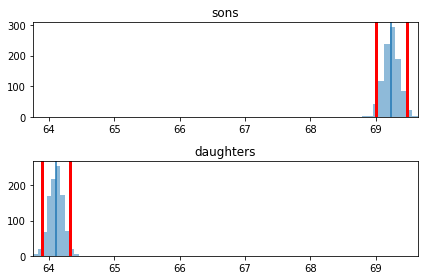

In [8]:
n_replicas = 1000

female_bootstrap_means = pandas.Series([
    female.sample(frac=1, replace=True).childHeight.mean()
    for i in range(n_replicas)])

male_bootstrap_means = pandas.Series([
        male.sample(frac=1, replace=True).childHeight.mean()
        for i in range(n_replicas)])

plot_dists(male_bootstrap_means, female_bootstrap_means, 
           nbins=80, a_label='sons', b_label='daughters')

The distribution of the bootstrap means do not overlap at all. Evidently, the difference is significant. 

**Your turn:** Compute and plot the bootstrap distribution of the mean of the heights of the fathers for male children. Compare this estimate to the bootstrap estimate of the mean of the heights of the sons. Are these means significantly different? 

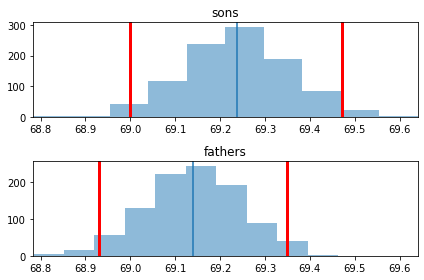

In [9]:
father_bootstrap_means = pandas.Series([
    male.sample(frac=1, replace=True).father.mean()
    for i in range(n_replicas)])

plot_dists(male_bootstrap_means, father_bootstrap_means, 
           nbins=80, a_label='sons', b_label='fathers')

### Bootstrap difference in means

In the previous example you computed and compared two bootstrap distributions of the means from the height data. It is actually quite easy to bootstrap a statistic such as the difference in means. 

In the cell below, we generate bootstrap samples from the full male+female dataset and then difference in the means of male and female `childHeight` for each sample, generating a distribution of sample mean `diffs`. 

Run the code and examine the plotted results.

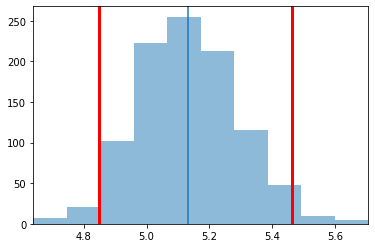

In [10]:
diffs = []
for i in range(n_replicas):
    sample = families.sample(frac=1.0, replace=True)
    male_sample_mean = sample[sample.gender == 'male'].childHeight.mean()
    female_sample_mean = sample[sample.gender == 'female'].childHeight.mean()
    diffs.append(male_sample_mean - female_sample_mean)
diffs = pandas.Series(diffs)

plot_hist(diffs, diffs.min(), diffs.max())

The distribution of the difference in means is far from zero. As before, we can infer that the means of the two populations are significantly different. 

But, is the distribution of the difference in means Normal as implied by the CLT. Run the code in the cell below to create a Q-Q Normal plot of the bootstrap distribution of the difference in means and examine the results. 

In [11]:
import statsmodels.api as sm

Text(0.5, 1.0, 'Quantiles of standard Normal vs. bookstrapped mean')

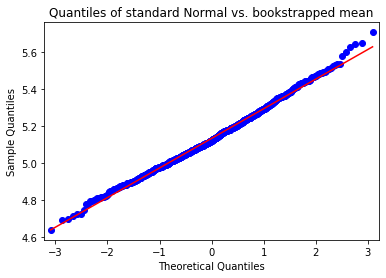

In [12]:
## Is the bootstrapped distribution Normal?
fig = sm.qqplot(diffs, line='s')
pyplot.title('Quantiles of standard Normal vs. bookstrapped mean')

The points on the Q-Q Normal plot are nearly on a strait line. Apparently, the bootstrap distribution of the difference in means does conform to the CLT.

**Your Turn:** In the cell below, create and run the code to compare the difference in means of adult sons to their fathers. Is the difference significant? Also, check if the distribution in the difference in means is approximately Normal. 

Text(0.5, 1.0, 'Quantiles of standard Normal vs. bootstrapped mean')

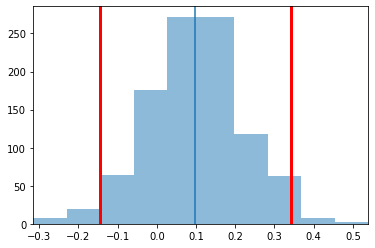

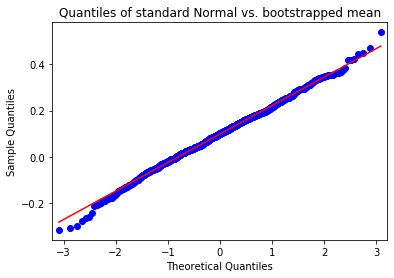

In [13]:
diffs = []
for i in range(n_replicas):
    sample = families.sample(frac=1.0, replace=True)
    male_sample_mean = sample[sample.gender == 'male'].childHeight.mean()
    father_sample_mean = sample[sample.gender == 'male'].father.mean()
    diffs.append(male_sample_mean - father_sample_mean)
diffs = pandas.Series(diffs)

plot_hist(diffs, diffs.min(), diffs.max())

fig = sm.qqplot(diffs, line='s')
pyplot.title('Quantiles of standard Normal vs. bootstrapped mean')

## Bootstraping other statistics

The bootstrap method can be applied to most any statistic. The code in the cell below computes the differnce in medians of the sons and the fathers. The median is an order statistic, and the values of a median are descretized by the quanta of the samples. Run this code and examine the results.

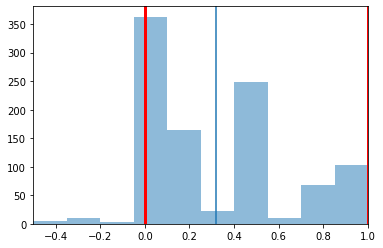

In [14]:
median_diffs = []
for i in range(n_replicas):
    sample = families.sample(frac=1.0, replace=True)
    male_sample_median = sample[sample.gender == 'male'].childHeight.median()
    father_sample_median = sample[sample.gender == 'male'].father.median()
    median_diffs.append(male_sample_median - father_sample_median)
median_diffs = pandas.Series(median_diffs)

plot_hist(median_diffs, median_diffs.min(), median_diffs.max())

The chart shows that the bootstrap distribution of the difference in medians. The confidence interval overlaps zero, so we must accept the null hypothesis that the difference in medians is zero.

You can also plot the Q-Q Normal plot of the bootstrap distribution of the difference in medians. Run the code in the cell below and examine the result.

Text(0.5, 1.0, 'Quantiles of standard Normal vs. bootstrapped median')

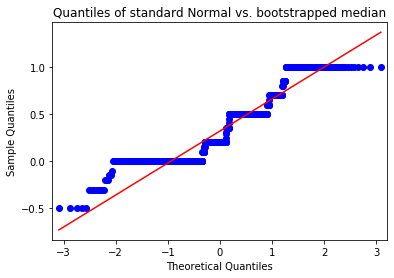

In [15]:
## Is the bootstrapped distribution Normal?
fig = sm.qqplot(median_diffs, line='s')
pyplot.title('Quantiles of standard Normal vs. bootstrapped median')

Keep in mind that the CLT only applies to sample means, not medians or any other statistic. None the less, you can see that the Q-Q Normal plot of the bootstrap distribution of the difference in meadians tends down the center diagonal of the plot. The zig-zag behavior arrises from the quanitzation inherent in the median.

## The Jack Knife

The jack knife is another resampline method. The jack knife is related to the bootstrap, but is a bit more restrictive in its application. Specifically, the jack knife:

- Re-computes a statistic N times with leave one out sample, where N is the sample size.
- Uses Random leave one (or n) out sampling.
- Only works for statistics with continuous derivatives.

For example, you can compute the bootstrap mean as:

$$MeanJK = \frac{\Sigma_i mean(sample_i)}{nsample}\\
where,\ for\ example\ with\ 10\ samples,\\
sample_i = X_1 + X_2 + X_3 + X_4 + X_5 + X_6 + X_8 + X_9 + X_{10}$$

A simple example of using a jack knife estimation of a mean is shown in the cell below. Run this code, examine the results and compare them to those obtainted with the bootstrap. 

In [16]:
print("We have %d male rows and %d female rows" % (len(male), len(female)))

We have 481 male rows and 453 female rows


We'll use the index of each row within a set (either `male` or `female`) to leave each of the observations (rows) out, one at a time.

In [17]:
# Re-number the rows in each set starting from zero or else the row indices
# would still match the original `families` dataframe we started with.
male = male.reset_index(drop=True)
female = female.reset_index(drop=True)

Now we can drop any particular row(s) we like and compute our jack knife sample mean on the remaining rows.

One trick to selecting all rows except for a given row index is the following, where we drop the row at index==3 (note the left-most column values skip 3).

In [18]:
male.drop(male.iloc[[3]].index).head()

,family,father,mother,midparentHeight,children,childNum,gender,childHeight
0,1,78.5,67.0,75.43,4,1,male,73.2
1,2,75.5,66.5,73.66,4,1,male,73.5
2,2,75.5,66.5,73.66,4,2,male,72.5
4,4,75.0,64.0,72.06,5,1,male,70.5
5,4,75.0,64.0,72.06,5,2,male,68.5


We can then compute a summary statistic of our choice on the rows that were not dropped like so:

In [19]:
male.drop(male.iloc[[3]].index).childHeight.mean()

69.23041666666673

Let's now use this strategy to leave each of the rows out, one at a time, and collect the summary statistics (child height mean) for each.

In [20]:
male_jk_means = pandas.Series([
        male.drop(male.iloc[[i]].index).childHeight.mean()
        for i in range(len(male))])

male_jk_means.describe()

count    481.000000
mean      69.234096
std        0.005466
min       69.213750
25%       69.230417
50%       69.234167
75%       69.237708
max       69.253333
dtype: float64

We can do the same for the gender==female subset of our data

In [21]:
female_jk_means = pandas.Series([
        female.drop(male.iloc[[i]].index).childHeight.mean()
        for i in range(len(female))])

female_jk_means.describe()

count    453.000000
mean      64.103974
std        0.005212
min       64.089823
25%       64.100885
50%       64.104204
75%       64.107522
max       64.121903
dtype: float64

## Cross Validation

Cross validation is a leave many out resampling technique. Cross validation uses multiple non-overlapping subsamples to train and test a data set. Basic cross validation uses the following steps:

- Divide dataset into N subsamples 
- N – 1 Folds train model 
- One Fold evaluate model

The basic concept of cross validation is illustrated below. 

![](img/CrossValidation.jpg)

Model performance is performed by looking at agregated summary statistics across the the trained models using the test data for each resample. The resampling reduces bias in the model performance statistics. Most importantly, cross validation reduces unpleasant suprises when a model is placed in production. 

The jack knife is an extreme end member of the family of cross validation methods. With the jack knife, the number of folds equals the number of data points. 

There are several variations on cross validation. The most commonly used in **nest cross validation**. In nested cross validaton, cross validation is performed on one or more models to compare performance.

